# Differential-Drive Car SLAM

We will revisit the [differential-drive car](https://en.wikipedia.org/wiki/Differential_wheeled_robot) to perform SLAM and estimate its state along with $N$ fixed landmark locations.

The state vector is now $\mathbf x = (x,y,\theta,m_{1x},m_{1y},...,m_{Nx},m_{Ny}) \in \mathbb R^{3+2N}$. The robot's motion model remains the same. Given two controls $\mathbf u = (u_1,u_2)$ corresponding to the angular velocities of its two wheels, fixed parameters $\rho$ and $L$, and timestep duration $\Delta t$, it evolves according to the nonlinear motion model 
$$\begin{align*}
    \begin{bmatrix} x_{k} \\ y_{k} \\ \theta_{k} \end{bmatrix} =
    \begin{bmatrix} x_{k-1} \\ y_{k-1} \\ \theta_{k-1} \end{bmatrix} + \Delta t
    \begin{bmatrix} \frac{\rho}{2} \cos\theta_{k-1} (u_{1,k}+u_{2,k}) \\
    \frac{\rho}{2} \sin\theta_{k-1} (u_{1,k}+u_{2,k}) \\
    \frac{\rho}{L} (u_{2,k}-u_{1,k}) \end{bmatrix} + \mathbf w_k
\end{align*}$$
where $\mathbf w_k \sim \mathcal N(\mathbf 0, Q)$. 

This time we will simplify the observation model so that the robot is able to sense the relative $(x,y)$ displacement from all landmarks. The measurement vector is thus $\mathbf z_k \in \mathbb R^{2N}$, following the **linear** observation model 
$$\mathbf z_k = \begin{bmatrix} m_{1x,k-1}-x_k \\ m_{1y,k-1}-y_k \\ \vdots \\ m_{Nx,k-1}-x_k \\ m_{Ny,k-1}-y_k \end{bmatrix} + \mathbf v_k$$
where $\mathbf v_k \sim \mathcal N(\mathbf 0, R)$. 

However, one additional complication is that the landmark measurements may be returned in any order. So in addition to the usual EKF functions, we will also need to perform data association.


## Robot Functions

The following are quantities and functions describing the true robot model. You should not modify these.

*   `WHEEL1_NOISE` and `WHEEL2_NOISE` are parameters describing the true robot model noise. `RFID` is a list of landmark positions. *Your robot should not make reference to these.*

*   `RHO` and `L` are known physical parameters of the robot. `N` is the known number of landmarks.

*   `Q` and `R` are covariance matrices used by your estimators.

*   The remaining variables describe the time interval, total simulation time, and the animation plot limits.

*   The functions `control`, `move`, `measure` implement the "true" physics and behavior of the robot.

In [163]:
import math
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

from scipy.stats import multivariate_normal
from scipy.spatial.transform import Rotation as Rot

In [164]:
# "True" robot noise (filters do NOT know these)
WHEEL1_NOISE = 0.05
WHEEL2_NOISE = 0.1
SENSOR_NOISE = 0.2*np.eye(2)

# Physical robot parameters (filters do know these)
RHO = 1
L = 1

# RFID positions [x, y]
N = 5
RFID = np.array([[-5.0, -5.0],
                 [10.0, 0.0],
                 [10.0, 10.0],
                 [0.0, 15.0],
                 [-5.0, 20.0]])

# Covariances used by the estimators
Q = 0.5*np.eye(3)
R = 0.5*np.eye(2*N)

# Other parameters
DT = 0.1         # time interval [s]
SIM_TIME = 20.0  # simulation time [s]

# Plot limits
XLIM = [-25,25]
YLIM = [-15,35]

In [165]:
"""
Robot physics
"""
def control(time, x):
    # Control inputs to the robot at a given time for a given state
    psi1dot = 3.7
    psi2dot = 4.0
    return np.array([psi1dot, psi2dot])

def move(x, u):
    # Physical motion model of the robot: x_k = f(x_{k-1}, u_k)
    # Incorporates imperfections in the wheels
    theta = x[2]
    psi1dot = u[0] * (1 + np.random.rand() * WHEEL1_NOISE)
    psi2dot = u[1] * (1 + np.random.rand() * WHEEL2_NOISE)

    velocity = np.array([RHO/2 * np.cos(theta) * (psi1dot+psi2dot),
                         RHO/2 * np.sin(theta) * (psi1dot+psi2dot),
                         RHO/L * (psi2dot - psi1dot)])

    return x + DT * velocity

def measure(x):
    # Physical measurement model of the robot: z_k = H(x_k)
    # Incorporates imperfections in the sensors and random ordering
    z = np.zeros((N,2))
    for i in range(N):
        z[i] = RFID[i] - x[0:2] + np.random.multivariate_normal(mean=(0,0), cov=SENSOR_NOISE)
    np.random.shuffle(z)
    return z.flatten()

## Plotting and Animation

The following code will run and visualize the results of EKF-SLAM. You should not modify these.

In [166]:
def run_EKF(x0, P0):
    ekf = EKF_SLAM(x0, P0)

    x_true = np.zeros((1,3))
    x_est = np.zeros((1,3+2*N))
    x_est[0] = ekf.x
    covariances = [ekf.P]

    time = 0.0
    while time <= SIM_TIME:
        time += DT
        u = control(time, x_true[-1])
        x = move(x_true[-1], u)
        z = measure(x)

        z = ekf.match(z)
        ekf.predict(u)
        ekf.update(z)

        x_est = np.vstack((x_est, ekf.x))
        x_true = np.vstack((x_true, x))
        covariances.append(ekf.P)

    plt.figure()
    robot_errors = x_true - x_est[:,0:3]
    plt.plot(np.abs(robot_errors))
    
    plt.legend(['x', 'y', 'th'])
    plt.xlabel('time')
    plt.ylabel('state error')
    plt.show()

    plt.figure()
    abs_disp = RFID.flatten() - x_est[:,3:]
    plt.plot(np.sum(np.abs(abs_disp), axis=1) / N)
    rel_disp = abs_disp - np.tile(robot_errors[:,0:2], (1,N))
    plt.plot(np.sum(np.abs(rel_disp), axis=1) / N)

    plt.legend(['absolute', 'relative'])
    plt.xlabel('time')
    plt.ylabel('landmark error')
    plt.show()

    return x_true, x_est, covariances

In [167]:
def animate_ekf(h_x_true, h_x_est, covariances):
    def animate(frame):
        true.set_data(np.array(h_x_true[:frame,0]).flatten(), np.array(h_x_true[:frame,1]).flatten())
        est.set_data(np.array(h_x_est[:frame,0]).flatten(), np.array(h_x_est[:frame,1]).flatten())
        est_lm.set_data(h_x_est[frame,3::2], h_x_est[frame,4::2])

        x, y = compute_ellipse(h_x_est[frame,0:2], covariances[frame][0:2,0:2])
        robot_ellipse.set_data(x, y)
        for l in range(RFID.shape[0]):
            x, y = compute_ellipse(h_x_est[frame,3+2*l:5+2*l], covariances[frame][3+2*l:5+2*l,3+2*l:5+2*l])
            lm_ellipses[l].set_data(x, y)

    fig, ax = plt.subplots()

    landmarks = ax.plot(RFID[:,0], RFID[:,1], "*k", label='true landmarks')
    true, = ax.plot([], [], "-b", label='true trajectory')
    est, = ax.plot([], [], "--r", label='estimated trajectory')
    est_lm, = ax.plot([], [], "*g", label='estimated landmarks')

    robot_ellipse, = ax.plot([], [], "m")
    lm_ellipses = []
    for l in range(RFID.shape[0]):
        lm_ellipse, = ax.plot([], [], "c")
        lm_ellipses.append(lm_ellipse)

    ax.axis('equal')
    ax.set_xlim(XLIM)
    ax.set_ylim(YLIM)
    ax.grid()
    ax.legend()

    anim = animation.FuncAnimation(fig, animate, frames=h_x_true.shape[0])
    return anim

In [168]:
def compute_ellipse(x, P):
    eigval, eigvec = np.linalg.eig(P)

    if eigval[0] >= eigval[1]:
        bigind = 0
    else:
        bigind = 1
    smallind = 1 - bigind

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])

    angle = math.atan2(eigvec[1, bigind], eigvec[0, bigind])
    rot = Rot.from_euler('z', angle).as_matrix()[0:2, 0:2]
    fx = rot @ (np.array([a * np.cos(t), b * np.sin(t)]))
    
    px = np.array(fx[0, :] + x[0]).flatten()
    py = np.array(fx[1, :] + x[1]).flatten()
    return px, py

# Part 1: Linearization (8 points)

To fully implement the extended Kalman filter, the model must be linearized. 

* Find the Jacobian $\mathbf F_k$ of the robot motion model, and write it out evaluated at the state mean $\mathbf{\hat x}_k$ and control input $\mathbf u_k$. You do not need to write out the components corresponding to the landmarks.

* The observation model is already linear. Identify the matrix $\mathbf H$ such that $\mathbf z_k = \mathbf H \mathbf x_k + \mathbf v_k$. As a hint, it should be a $2N \times (2N+3)$ matrix.

$F_k = \begin{bmatrix}
1&0&-\frac{\rho}{2}\Delta t(u_{1k}+u_{2,k})\sin\hat{\theta}_k\\
0 & 1 & \frac{\rho}{2}\Delta t(u_{1k}+u_{2,k})\cos\hat{\theta}_k \\
0 & 0 & 1
\end{bmatrix}$

$H = \begin{bmatrix}
-1&0&0&\\
0&-1&0& \\
-1&0&0& \\
.&.&.&&&I_{2N\times2N}\\
.&.&.\\
.&.&.\\
-1&0&0&\\
0&-1&0&\\
\end{bmatrix}$

# Part 2: EKF-SLAM (24 points)

Now you can complete the `EKF_SLAM` class below. The fields `self.x` and `self.P` store the current state vector and covariance matrix. The initial state and covariance must be provided when initializing the filter.

* `predict()` should apply the nonlinear motion model directly to the mean, while the covariance matrix update will use the linearized model that you found above. Remember that the landmarks do not move and have no associated motion uncertainty.

* `update()` should update the state mean and covariance given a correctly ordered vector of displacement measurements. This should be fairly straightforward upon construction of the $\mathbf H$ matrix that you found above.

* `match()` takes an array of displacement measurements and associates them to the EKF landmark components. Since the robot does not move very far between measurements, it would suffice to perform closest-point matching between the "expected" landmark locations (according to the measurements) and the "previous" landmark locations in the state vector. Return the correctly ordered measurement vector when done.

In [169]:
class EKF_SLAM():
    def __init__(self, x0, P0):
        self.x = x0
        self.P = P0


    def predict(self, u):
        """
        :param u: Robot inputs (u1,u2) [size 2 array]
        Perform motion prediction and update state mean and covariance in place
        """
        theta = self.x[2]
        u1 = u[0] 
        u2 = u[1]

        velocity = np.array([RHO/2 * np.cos(theta) * (u1+u2),
                         RHO/2 * np.sin(theta) * (u1+u2),
                         RHO/L * (u2 - u1)])

        self.x[0:3] = self.x[0:3] + (DT * velocity) 

        lin_F =  np.array([[1, 0, RHO/2 * -1 * DT * np.sin(theta) * (u1+u2)],
                         [0, 1, RHO/2 * DT * np.cos(theta) * (u1+u2)],
                         [0, 0, 1]])
       
        B = np.zeros((3, 2 * N))
        C = np.zeros((2 * N, 3))
        I = np.eye(2*N)
        F_k = np.block([[lin_F, B],[C, I]])
        self.P = F_k @ self.P @ F_k.T
        self.P[0:3, 0:3] += Q
    
    def createH(self):
        H = np.zeros((2 * N, 3 + (2*N)))
        x = True
        m_i = 3
        for i in range(2*N):
            for j in range(0, 2):
                if j == 0 and x==True: H[i,j] = -1
                elif j == 1 and x==False: H[i,j] = -1
            x = not x
            H[i, m_i] = 1
            m_i += 1
        return H

    def update(self, z):
        """
        :param z: Associated displacement measurements (dx, dy) from each landmark [size 2N array]. 
        Perform measurement update and update state mean and covariance in place
        """
        H = self.createH()
        S = (H @ self.P @ H.T) + R
        K = self.P @ (H.T @ np.linalg.inv(S))
        y = z - (H @ self.x)
        self.x = self.x + (K @ y)
        self.P = (np.eye(2*N + 3)-(K @ H)) @ self.P

   
    def match(self, z):
        """
        :param z: Shuffled displacement measurements (dx, dy) from each landmark [size 2N array]. 
        Perform data association and return a correctly ordered measurement array
        """    
        z_shaped = z.reshape(N, 2) 
        H = self.createH()
        preds = (H @ self.x).reshape(N, 2)
        S = (H @ self.P @ H.T) + R
        probs = np.zeros(N)
        new_z = np.zeros((N, 2))
        taken = []
        for landmark in z_shaped:
            start = 0
            end = 2
            for i, pred in enumerate(preds):
                S_submatrix = S[start:end, start:end]
                if i in taken: probs[i] = -np.Inf
                else: probs[i] = multivariate_normal.pdf(landmark, mean=pred, cov=S_submatrix)
                start += 2
                end += 2 
            new_z[np.argmax(probs)] = landmark
            taken.append(np.argmax(probs))
        return new_z.flatten()               

Once you have finished your implementation, you can invoke `run_EKF()` with the initial state and covariance as arguments. The robot's true state starts at the origin. After the simulation, the following plots are shown:

* The error between the estimated mean and the actual robot state values.
* The average absolute error between the estimated mean and the actual landmark position values.
* The average *relative* error between the estimated mean and the actual landmark position values, computed as the difference between the second and first errors above. This finds the landmark error component that is *not* due to robot state error.

You can also generate an animation of the robot's motion over time, showing the actual and estimated trajectory, and actual and estimated landmark positions, and covariance ellipses around the estimated quantities.

We recommend that you output one animation at a time to keep the kernel stable. 

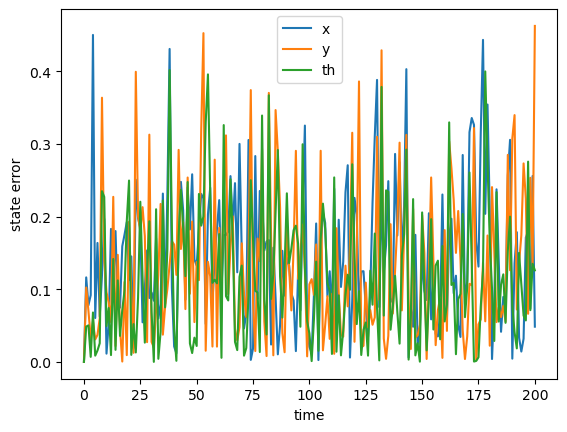

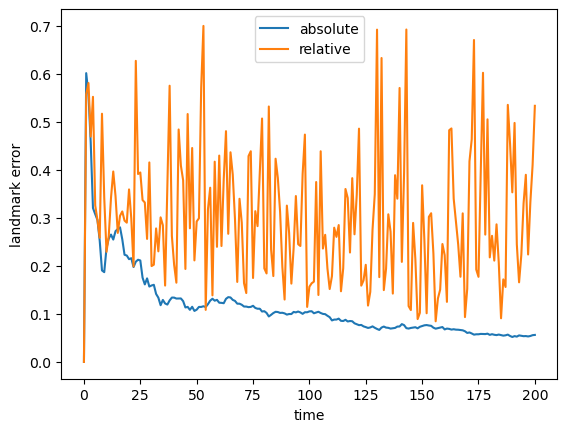

In [159]:
x0 = [0, 0, 0, -5.0, -5.0, 10.0, 0.0, 10.0, 10.0, 0.0, 15.0, -5.0, 20.0]
P0 = np.eye(3+2*N)
x_true, x_est, covariances = run_EKF(x0, P0)

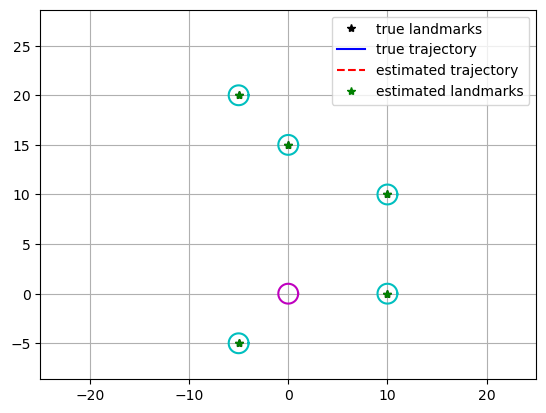

In [160]:
anim = animate_ekf(x_true, x_est, covariances)
HTML(anim.to_html5_video())

# Part 3: Discussion (8 points)

Before you run the experiments below, you should verify that you have a working implementation with the sample commands above. While the plots will look noisy, the actual errors should all be relatively low and the animation should show the robot and landmarks all in the right place with low uncertainty. We should expect this to be the case, since we actually initialized $\mathbf x_0$ with all the correct locations.

For parts 1-3 below, run the EKF with the specified initialization, and show the error plots. Then briefly address the following questions. We can use a loose definition of "convergence", where a value remains relatively constant and close to 0 over time.

 * Are we able to achieve absolute convergence in the robot state (localization) and landmark locations (map)? Why or why not?
 * Are we able to achieve relative convergence in the landmark locations? Why or why not? 

1. Run EKF-SLAM with $\mathbf x_0 = \mathbf 0$ and $P_0 = \mathbf I$.

2. Run EKF-SLAM with $\mathbf x_0 = \mathbf 0$ and $P_0 = \mathbf 0$.

3. Run EKF-SLAM with $\mathbf x_0 = \mathbf 0$ and $P_0 = \begin{bmatrix} P_{xx} & P_{mx} \\ P_{mx}^\top & P_{mm} \end{bmatrix}$, with $P_{xx} = \mathbf 0$ and $P_{mm} = \mathbf I$.

4. Run EKF-SLAM with $\mathbf x_0 = \mathbf 0$. For this part, you should initialize the covariance matrix so that we able to achieve absolute convergence in both the robot state and landmark locations. Try to use your observations above to help with this, and explain why your initialization works. 

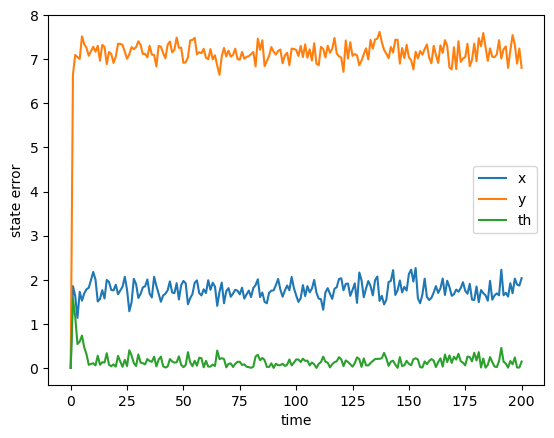

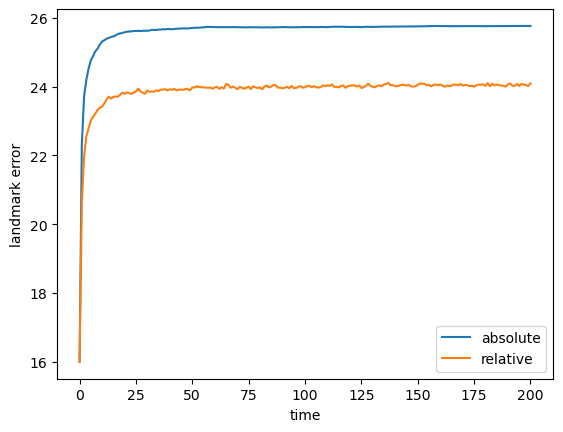

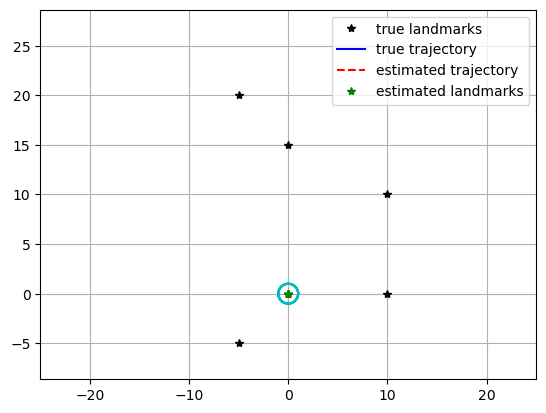

In [161]:
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P0 = np.eye(3+2*N)
x_true, x_est, covariances = run_EKF(x0, P0)
anim = animate_ekf(x_true, x_est, covariances)
HTML(anim.to_html5_video())

We don't achieve absolute convergence since the mean state and landmark positions are offset by a constant dispalcement. The landmark positions achieve relative convergence, however. 


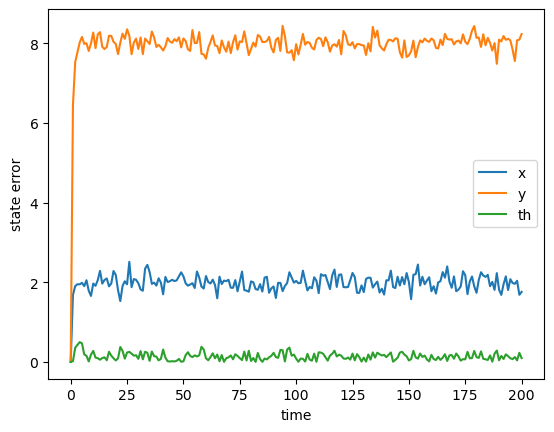

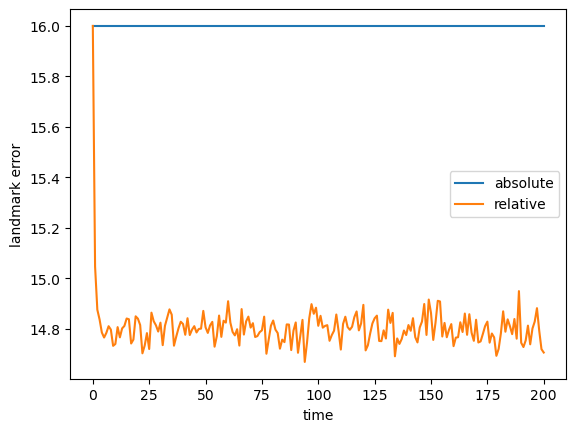

In [162]:
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P0 = np.zeros((2*N + 3, 2*N + 3))
x_true, x_est, covariances = run_EKF(x0, P0)
anim = animate_ekf(x_true, x_est, covariances)
HTML(anim.to_html5_video())

The estimated landmarks stay in the same postion since the initial uncertainy is 0 so we don't achieve relative or absolute convergence.

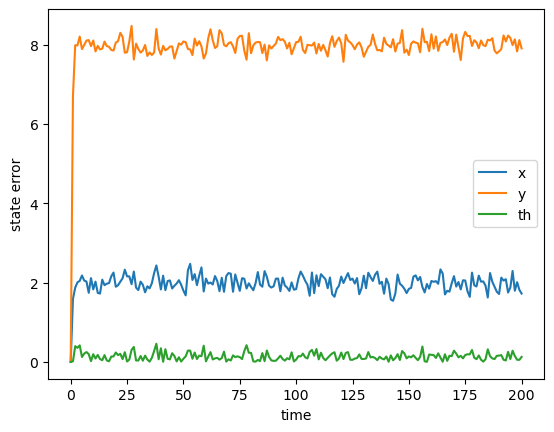

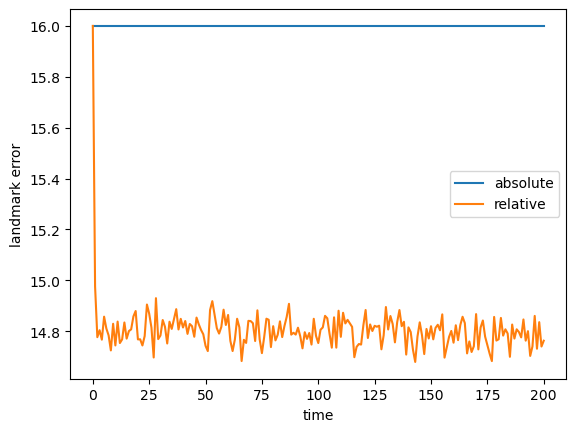

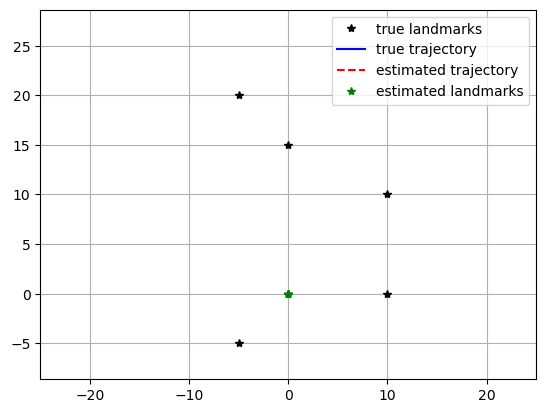

In [135]:
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
xx = np.zeros((3, 3))
mx = np.zeros((3, 2 * N))
mm = np.eye(2*N)
P_0 = np.block([[xx, mx],[mx.T, mm]])
x_true, x_est, covariances = run_EKF(x0, P0)
anim = animate_ekf(x_true, x_est, covariances)
HTML(anim.to_html5_video())

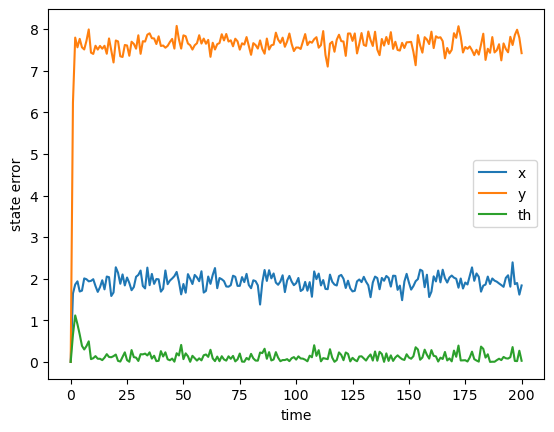

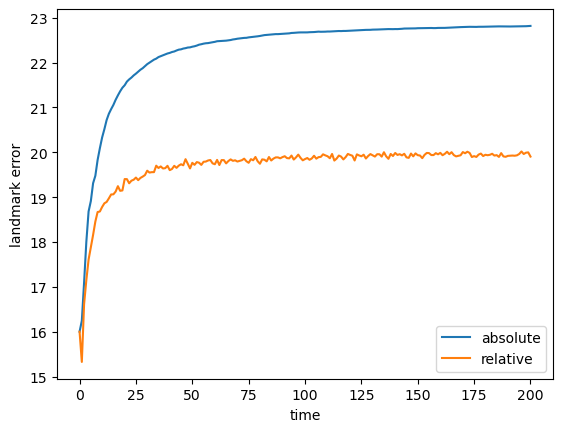

In [172]:
x0 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
P0 = 0.2 * np.eye(2*N + 3)
x_true, x_est, covariances = run_EKF(x0, P0)
anim = animate_ekf(x_true, x_est, covariances)
HTML(anim.to_html5_video())